<h1 style="text-align:center;"><a href="https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=credits.csv">The Movies Dataset
</a></h1>

Group Number: #127
<br>
Names: Alex Oprea, Kristen Duong
<br>
Student Numbers: 300230368, 300240425

# INTRODUCTION

This notebook will complete 5 different studies on The Movies dataset. We will first perform similarity measures on different attributes, test 2 different clustering algorithms, develop a content-based recommendation system from 2 similarity heuristics, and finally, program a recommendation system based on collaborative filtering.

To use the notebook, click the "Run All Cells" button (i.e., run all cells in the order that they are written in). Also ensure that you have installed on your device all the required libraries to be imported (listed at the beginning of the first code cell).

# DESCRIPTION

<i>Dataset name:</i> The Movies Dataset
<br>
<i>Author:</i> Rounak Banik
<br>
<i>Purpose:</i> This dataset was created to practice building a content-based and collaborative filtering-based recommendation engine. This is done by using the movie metadata dataset in addition to the ratings (small) dataset. The recommendation system created should be to rank movies based on a user's request and show the results.
<br>
<i>Domain:</i> Film and Entertainment Industry
<br>
<i>Audience:</i> Film analysts and researchers wanting to explore movie trends and audience preferences over the years. Those interested in building recommendation systems would also benefit from this dataset, as they can explore the information given to make a model that recommends movies to people based on their interests and the community's. People can also explore various clustering algorithms and visualize which works best by changing parameters and attribute combinations.
<br>
<i>Metadata Dataset Shape:</i> 45, 466 rows, 24 columns
<br>
<i>Ratings_Small Dataset Shape:</i> 100, 004 rows, 4 columns

<br>
<b>Metadata Attributes</b>

<i>Categorical Attributes:</i>
- adult: Boolean value representing whether the movie is an adult film or not
- belongs_to_collection: Specifies the movie series the movie belongs to
- genres: The genre type of the movie
- original_language: The movie's language
- production_companies: The company(ies) that produced the movie
- production_country: The country the movie was produced in
- spoken_languages: The language the movie is spoken in
- status: Whether the movie was released or not
- original_title: The original title of the movie
- title: The movie's title


<i>Numerical Attributes:</i>
- budget: The amount of money invested to produce the movie
- popularity: How popular the movie is.
- runtime: The movie's length
- revenue: How much the movie made
- release_date: The date the movie was released
- vote_average: Average rating of the movie (scored 1 to 10)
- vote_count: The number of votes received

<i>Others:</i>
These are neither categorical nor numerical. These attributes have values that provide additional information about the movie, but are not needed for this assignment
- homepage: The homepage link for the movie
- overview: The synopsis of the movie
- tagline: The movie's tagline (if it has one)
- poster_path: The link to the movie's poster image

<i>Unused Attributes:</i>
These attributes will not be used in any of the studies as they are irrelevant for this assignment
- id: The ID associated with each movie
- imdb_id: The related IMDb ID for the movie
- video: Repetative attribute since it indicates if an official video has been released. This overlaps with the status attribute

<br>
<b>Ratings_Small Attributes</b>

<i>Categorical Attributes:</i>
- None

<i>Numerical Attributes:</i>
- userId: The ID of the user
- movieID: The ID of the movie
- rating: The rating the user made for the movie (score from 0.5 to 5)
- timestamp: The time the user made the rating

## SET UP

In [32]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from math import*
import Levenshtein
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import defaultdict

# load csv files from github
metadata = pd.read_csv(
    'https://raw.githubusercontent.com/kkristene3/CSI4142_Datasets/refs/heads/main/movies_metadata.csv',
    dtype={10: str}  # change column 10 to string values
)
ratings = pd.read_csv('https://raw.githubusercontent.com/kkristene3/CSI4142_Datasets/refs/heads/main/ratings_small.csv')


## CLEANING DATASET


Presence Check (ratings): Pass

Presence Check (metadata dataset): 
NaN values in 'revenue' before: 0
NaN values in 'budget' before: 3
NaN values in 'runtime' before: 263
NaN values in 'revenue' after: 0
NaN values in 'budget' after: 0
NaN values in 'runtime' after: 0

We will visualize how the budget distribution changes before and after we imputate the mean values.


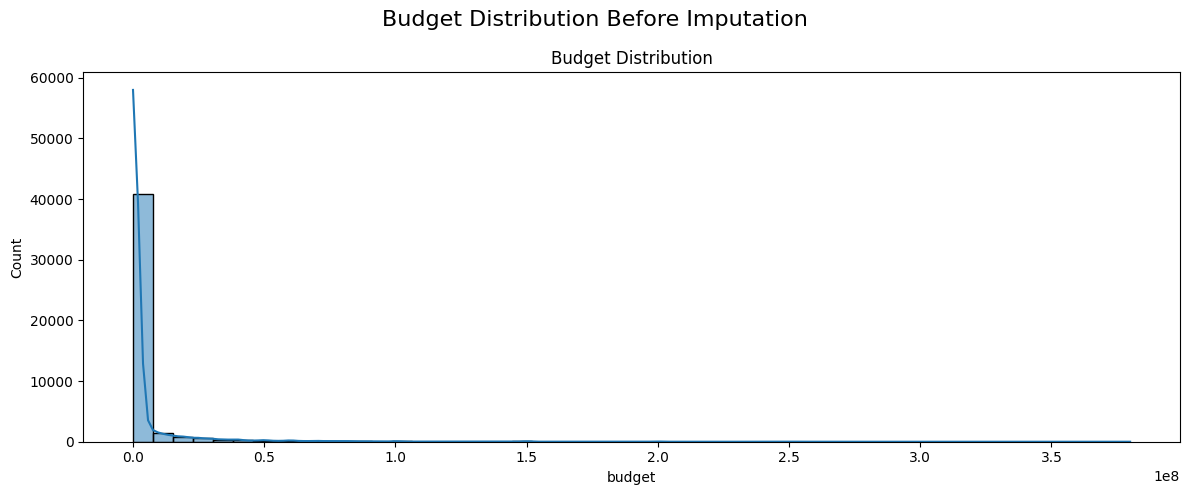


Range Checker (metadata): Given that it's impossible to create a movie with a budget of 0, we will impute those rows with the mean of that column.
Number of zero values before budget row imputation: 36573
Number of zero values after budget imputation: 0


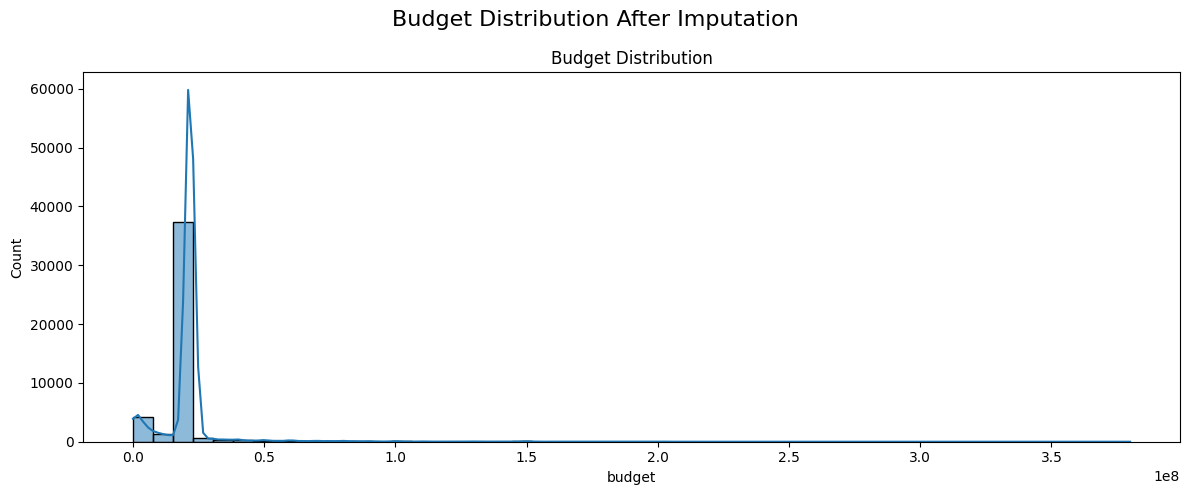

After impututing the 0 values, the data now reflects a more realistic range of movie budgets. There is also less bias towards lower budgets. Considering there were 36573 values with a budget=0.


In [33]:

# -------------------------------------------------------------- PRESENCE CHECKER -----------------------------------------------------------------
# THIS CHECKER WILL CHECK FOR ANY MISSING VALUES IN THE RATINGS DATASET
# sum up the number of null values in each column
missing_values = ratings.isnull().sum()

# print results
if missing_values.any():
    print(missing_values[missing_values > 0])
else:
    print("\nPresence Check (ratings): Pass")

# THIS CHECK WILL CHECK FOR ANY NaN VALUES IN THE METADATA DATASET IN THE COLUMNS REVENUE AND BUDGET, IT WILL IMPUTATE THE MEAN IF VALUE IS NAN
print("\nPresence Check (metadata dataset): ")

# convert attributes values to numerics 
metadata['budget'] = pd.to_numeric(metadata['budget'], errors='coerce')  # convert non-numerics to NaN
#metadata['revenue'] = pd.to_numeric(metadata['revenue'], errors='coerce')  # convert non-numerics to NaN

# Fill NaN values in 'revenue' with the mean
metadata['revenue'] = metadata['revenue'].fillna(metadata['revenue'].mean())

# Before count of NaN values
print("NaN values in 'revenue' before:", metadata['revenue'].isna().sum())
print("NaN values in 'budget' before:", metadata['budget'].isna().sum())
print("NaN values in 'runtime' before:", metadata['runtime'].isna().sum())

# imputate
metadata['revenue'] = metadata['revenue'].fillna(metadata['revenue'].mean())
metadata['budget'] = metadata['budget'].fillna(metadata['budget'].mean())
metadata['runtime'] = metadata['runtime'].fillna(metadata['runtime'].mean())

# after count
print("NaN values in 'revenue' after:", metadata['revenue'].isna().sum())
print("NaN values in 'budget' after:", metadata['budget'].isna().sum())
print("NaN values in 'runtime' after:", metadata['runtime'].isna().sum())


# --------------------------------------------------------------- EDA : PART 1 ---------------------------------------------------------------
print("\nWe will visualize how the budget distribution changes before and after we imputate the mean values.")

# visualize budget and revenue distributions
fig, ax = plt.subplots(figsize=(12, 5))  # Create a single axis (not an array of axes)

# Budget Distribution
sns.histplot(metadata['budget'], bins=50, kde=True, ax=ax)  # Pass the single axis to ax

ax.set_title('Budget Distribution')

# show plots
fig.suptitle('Budget Distribution Before Imputation', fontsize=16)
plt.tight_layout()
plt.show()
# --------------------------------------------------------- RANGE CHECKER & IMPUTATION ---------------------------------------------------------
# THIS CHECKER WILL RUN ON THE METADATA DATASET, ON THE BUDGET COLUMN
print("\nRange Checker (metadata): Given that it's impossible to create a movie with a budget of 0, we will impute those rows with the mean of that column.")

# get the number of budget = 0 values before removal
print(f"Number of zero values before budget row imputation: {(metadata['budget'] == 0).sum()}")

# Create a copy of metadata without 0 values in budget and revenue (the subset to use in study 2)
metadata_nonzero = metadata.copy()
metadata_nonzero = metadata_nonzero[(metadata['budget'] != 0) & (metadata['revenue'] != 0)]

# calculate the average in the budget column
average = metadata.loc[metadata['budget'] > 0, 'budget'].mean()

# replace the budget values equal to 0 with the average calculated
metadata.loc[metadata['budget'] == 0, 'budget'] = average

# get the number of budget = 0 values after row removal
print(f"Number of zero values after budget imputation: {(metadata['budget'] == 0).sum()}")

# --------------------------------------------------------------- EDA : PART 2 ---------------------------------------------------------------
# visualize budget and revenue distributions
fig, ax = plt.subplots(figsize=(12, 5)) 

# Budget Distribution
sns.histplot(metadata['budget'], bins=50, kde=True, ax=ax)

ax.set_title('Budget Distribution')

# show plots
fig.suptitle('Budget Distribution After Imputation', fontsize=16)
plt.tight_layout()
plt.show()

print("After impututing the 0 values, the data now reflects a more realistic range of movie budgets. There is also less bias towards lower budgets. Considering there were 36573 values with a budget=0.")

## STUDY 1 - Similarity Measures

This study will simulate 5 requests to show the results of different similarity measures. Four similarity measures have been explored for this study. Jaccard, Manhattan, Euclidean, and a textual similarity measure, Levenshtein, will be used to show the Top 10 results based on our chosen criteria.

For Jaccard, we will compare similar movie genres to Toy Story. We will also compare similar spoken languages to The Usual Suspects.
For Manhattan, we will compare years similar to Twilight.
For Euclidean, we will compare similar runtimes to Titanic.
For Levenshtein, we will compare similar original titles to Fight Club.

In [34]:
# 5 attributes chosen
subsets = ['genres', 'revenue', 'budget', 'runtime', 'original_title']

metadata.reset_index(drop=True, inplace=True)


# -------------------------------------------------------------------- SET UP --------------------------------------------------------------------

# check if values are JSON in string form, then convert JSON-like strings to a python object
genres_parsed = metadata['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
spoken_languages_parsed = metadata['spoken_languages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# get the the name value from each list of dictionaries (store it in an array)
genre_names = genres_parsed.apply(lambda x: ", ".join([genre['name'] for genre in x]) if isinstance(x, list) else "")
spoken_languages_names = spoken_languages_parsed.apply(lambda x: ", ".join([language['name'] for language in x]) if isinstance(x, list) else "")

# header
print("RESULTS:")

# ---------------------------------------------------------- SIMILARITY TEST 1 : Jaccard ----------------------------------------------------------
# similarity test (Jaccard) for movies genres similar to: Toy Store (the first movie in the dataset)
print("\nShow me movies of the same genre as \"Toy story\"", "(genre is: " + genre_names[0] + ").")

# function to calculate the jaccard similarity
def jaccard_similarity(x,y):
     set_x, set_y = set(x.split(", ")), set(y.split(", ")) # convert the strings to a set of words
    
     intersection_cardinality = len(set_x & set_y) # do intersection of sets
     union_cardinality = len(set_x | set_y) # do union of sets
    
     return intersection_cardinality/float(union_cardinality) # return the score

# calculate the Jaccard score for genres
genre_scores = []
for i in range (len(genre_names)):
    if i != 0:
        genre_scores.append((i, jaccard_similarity(genre_names[0], genre_names[i]))) # add index and jaccard score to array

# get the index of the top 10 scores
genre_scores.sort(key=lambda x: x[1], reverse=True) # sort in descending
top_10_genre = genre_scores[:10] # get top 10 scores (ignore the first one)

# print results
count = 1
for index, score in top_10_genre:
    print(str(count) + ". TITLE:", metadata.iloc[index]['original_title'] + ", \nGENRE(s):", genre_names[index] 
          + ", \nRUNTIME:", metadata.iloc[index]['runtime'], "mins" + ", \nLANGUAGE(s):", spoken_languages_names[index])
    count += 1

# --------------------------------------------------------- SIMILARITY TEST 2 : Manhattan ---------------------------------------------------------
# compare revenue of other movies to:  Twilight
twilight_row = 13133
print("\nShow me movies with similar revenue to: \"Twilight\"", "(revenue is:", str(metadata.iloc[twilight_row]['revenue']) + ").")

# function to calculate manhattan distance
def manhattan_distance(x, y):
    return abs(x - y)

# calculate manhattan distance between years
revenue_distances = []
for i in range (len(metadata['revenue'])):
    if i != twilight_row: # skip Twilight index
        revenue_distances.append((i, manhattan_distance(metadata.iloc[twilight_row]['revenue'], metadata.iloc[i]['revenue']))) # add index and manhattan score to array

# get the index of the top 10 scores
revenue_distances.sort(key=lambda x: x[1]) # sort in ascending
top_10_revenue= revenue_distances[:10]

# print top 10
count = 1
for index, score in top_10_revenue:
    print(str(count) + ". TITLE:", metadata.iloc[index]['original_title'] + ", \nREVENUE:", str(metadata.iloc[index]['revenue'])
          + ", \nGENRE(s):", genre_names[index] + ", \nRUNTIME:", metadata.iloc[index]['runtime'], "mins" 
          + ", \nLANGUAGE(s):", spoken_languages_names[index])
    count += 1


# --------------------------------------------------------- SIMILARITY TEST 3 : Euclidean ---------------------------------------------------------
# similarity test for movies with similar revenue to: Titanic
titanic_row = metadata[metadata['original_title'] == "Titanic"].index[0]
print("\nShow me movies with similar runtime as \"Titanic\"", "(runtime is: " + str(metadata.iloc[titanic_row]['runtime']) + " mins).")

# function to calculate the euclidean similarity (for scalars)
def euclidean_distance(x,y):
   return abs(x - y)
    
# calculate Euclidean distance
runtime_distance = []
for i in range (len(metadata['runtime'])):
    if i != titanic_row: # skip Titanic index
        runtime_distance.append((i, euclidean_distance(metadata.iloc[titanic_row]['runtime'], metadata.iloc[i]['runtime']))) # add euclidean distance to array

# get the index of the top 10 scores
runtime_distance.sort(key=lambda x: x[1]) # sort in ascending
top_10_runtime = runtime_distance[:10]

# print top 10
count = 1
for index, score in top_10_runtime:
    print(str(count) + ". TITLE:", metadata.iloc[index]['original_title'] + ", \nRUNTIME:", metadata.iloc[index]['runtime'], "mins" 
          + ", \nGENRE(s):", genre_names[index] + ", \nLANGUAGE(s):", spoken_languages_names[index])
    count += 1

# ---------------------------------------------------------------- PART 2: ------------------------------------------------------------------------

# similarity test for movies of similar budget to The Usual Suspects
the_usual_suspects_row = metadata[metadata['original_title'] == "The Usual Suspects"].index[0]
print("\nShow me movies of the similar budget as \"The Usual Suspects\"", "(budget is: " + str(metadata.iloc[the_usual_suspects_row]['budget']) + ").")

# calculate Euclidean score
budget_scores = []
for i in range (len(metadata['budget'])):
    if i != the_usual_suspects_row: # skip The Usual Suspects index
        budget_scores.append((i, euclidean_distance(metadata.iloc[the_usual_suspects_row]['budget'], metadata.iloc[i]['budget']))) # add index and euclidean distance to array

# get the index of the top 10 scores
budget_scores.sort(key=lambda x: x[1])  # Sort in ascending order
top_10_budget = budget_scores[:10] # get top 10 scores

# output results
count = 1
for index, score in top_10_budget:
   print(str(count) + ". TITLE:", metadata.iloc[index]['original_title'] + ", \nBUDGET:", str(metadata.iloc[index]['budget'])
         + ", \nLANGUAGE(s):", spoken_languages_names[index] + ", \nGENRE(s):", genre_names[index] 
          + ", \nRUNTIME:", metadata.iloc[index]['runtime'], "mins")
   count += 1


# ------------------------------------------------------- SIMILARITY TEST 4 : Levenshtein  -------------------------------------------------------
# compare titles of different length to: Fight Club
fight_club_row = metadata[metadata['original_title'] == "Fight Club"].index[0]
print("\nShow me movies with similar title to \"Fight Club\".")

def levenshtein_distance(x, y):
    return Levenshtein.distance(x, y)

# calculate Levenshtein score
title_scores = []
for i in range (len(metadata['original_title'])):
    if i != fight_club_row:
        title_scores.append((i, levenshtein_distance(metadata.iloc[fight_club_row]['original_title'], metadata.iloc[i]['original_title']))) # add levenshtein distance to array

# get the index of the top 10 scores
title_scores.sort(key=lambda x: (x[1], abs(len(metadata.iloc[x[0]]['original_title']) - len(metadata.iloc[fight_club_row]['original_title']))))
top_10_title = title_scores[:10]

# print top 10
count = 1
for index, score in top_10_title:
    print(str(count) + ". TITLE:", metadata.iloc[index]['original_title'] + ", \nRELEASE DATE:", metadata.iloc[index]['release_date']  
          + ", \nGENRE(s):", genre_names[index] + ", \nRUNTIME:", metadata.iloc[index]['runtime'], "mins" 
          + ", \nLANGUAGE(s):", spoken_languages_names[index])
    count += 1


RESULTS:

Show me movies of the same genre as "Toy story" (genre is: Animation, Comedy, Family).
1. TITLE: Oliver & Company, 
GENRE(s): Animation, Comedy, Family, 
RUNTIME: 74.0 mins, 
LANGUAGE(s): English
2. TITLE: A Close Shave, 
GENRE(s): Family, Animation, Comedy, 
RUNTIME: 30.0 mins, 
LANGUAGE(s): English
3. TITLE: The Wrong Trousers, 
GENRE(s): Animation, Comedy, Family, 
RUNTIME: 30.0 mins, 
LANGUAGE(s): English
4. TITLE: Meet the Deedles, 
GENRE(s): Animation, Comedy, Family, 
RUNTIME: 93.0 mins, 
LANGUAGE(s): English
5. TITLE: The Great Mouse Detective, 
GENRE(s): Comedy, Animation, Family, 
RUNTIME: 74.0 mins, 
LANGUAGE(s): English
6. TITLE: Doug's 1st Movie, 
GENRE(s): Animation, Family, Comedy, 
RUNTIME: 77.0 mins, 
LANGUAGE(s): English
7. TITLE: Toy Story 2, 
GENRE(s): Animation, Comedy, Family, 
RUNTIME: 92.0 mins, 
LANGUAGE(s): English
8. TITLE: Creature Comforts, 
GENRE(s): Animation, Comedy, Family, 
RUNTIME: 5.0 mins, 
LANGUAGE(s): English, Deutsch
9. TITLE: Chicken R

## STUDY 2 - Clustering algorithms

This study will test two clustering algorithms, KMeans and DBSCAN. The two combinations of two attributes will be Revenue vs. Budget and Runtime vs. Budget. Before plotting the clusters, we scaled (standardized) both combinations to ensure that both features contribute equally to the clustering process.

- For KMeans, we will test 2 values for k. Using the elbow method, we determined 2 values to use for the parameter k. From the elbow curve visualized, we found that k = 3 and k = 4 would work best.

- For DBSCAN, we will test 2 values for eps and min_samples. For the first variation, we chose an epsilon of 0.5 and min_sample of 4. For the second variation, we chose the values: ep = 0.35 and min_samples = 5.

After calculating the clusters using both algorithms and varied parameters, we plotted them and performed a visual inspection/comparison of which seemed more appropriate. See this study's conclusion for our results.

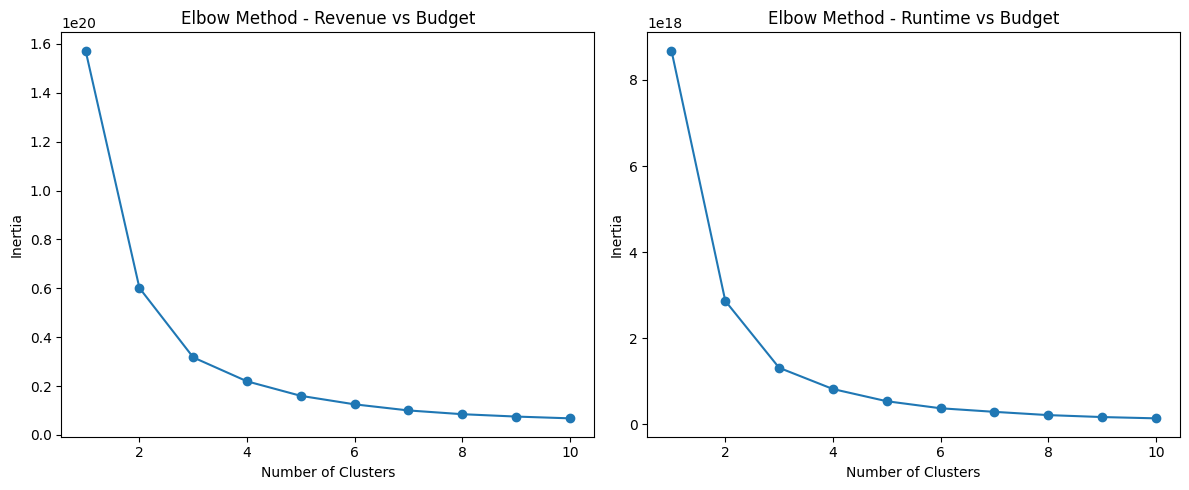

In [35]:
# turn the data values of the two attributes chosen into a set of points
first_combo = list(zip(metadata_nonzero['revenue'], metadata_nonzero['budget']))
second_combo = list(zip(metadata_nonzero['runtime'], metadata_nonzero['budget']))

# Standardize the data
scaler = StandardScaler()
first_combo_scaled = scaler.fit_transform(first_combo)
second_combo_scaled = scaler.fit_transform(second_combo)

# --------------------------------------------------------------- DETERMINE K VALUES --------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First combination -------------------------------------------------------------------------------------------------------------------------------
inertias = []
for i in range(1, min(10, len(first_combo)) + 1):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(first_combo)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
axes[0].plot(range(1, min(10, len(first_combo)) + 1), inertias, marker='o')
axes[0].set_title('Elbow Method - Revenue vs Budget')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')

# Second combination -----------------------------------------------------------------------------------------------------------------------------
inertias = []
for i in range(1, min(10, len(second_combo)) + 1):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(second_combo)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
axes[1].plot(range(1, min(10, len(second_combo)) + 1), inertias, marker='o')
axes[1].set_title('Elbow Method - Runtime vs Budget')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Inertia')

# Show both curves
plt.tight_layout()
plt.show()


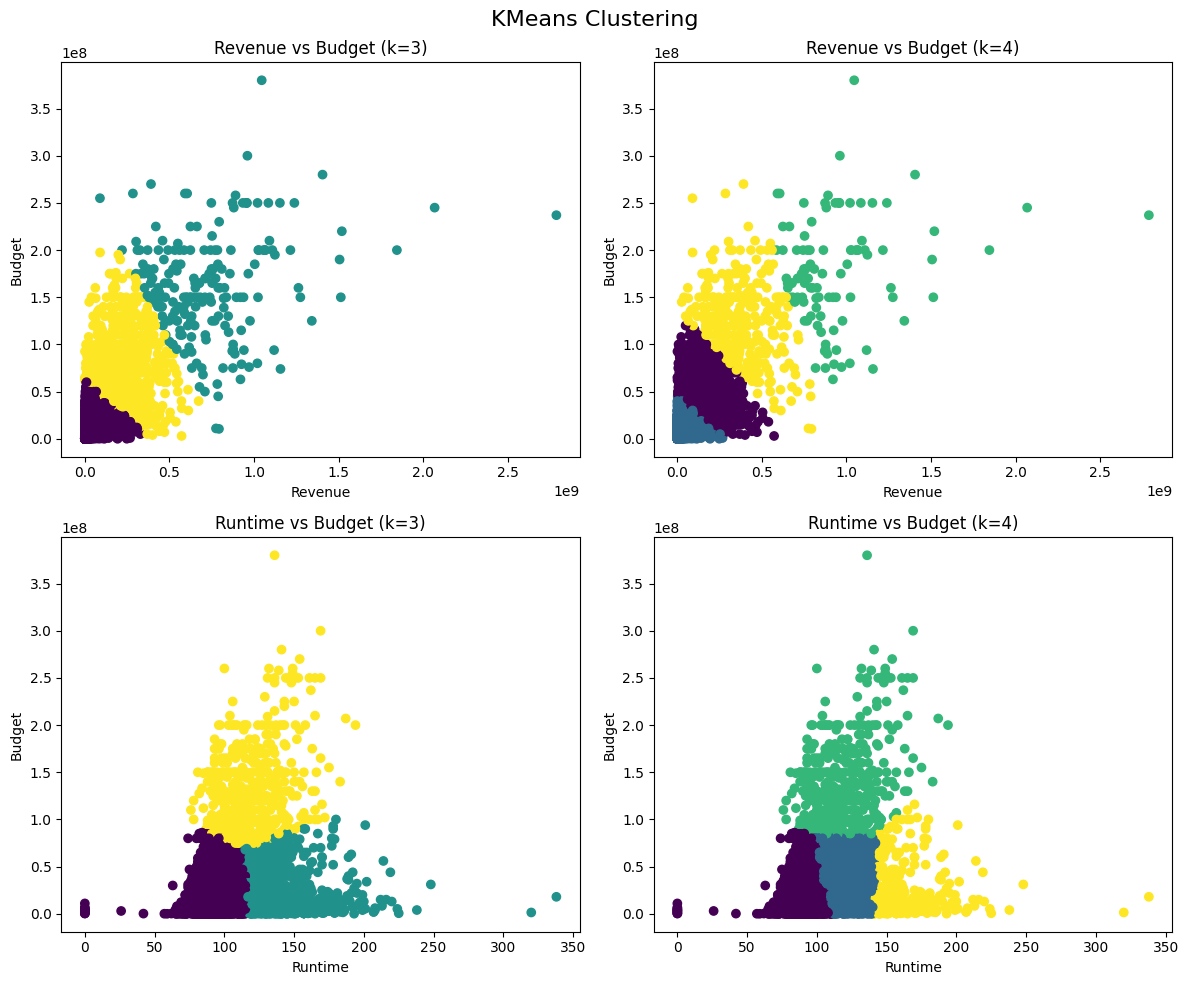

In [36]:
# --------------------------------------------------------------- KMEANS CLUSTERING ---------------------------------------------------------------

# Set up 
k_values = [3, 4]
fig, axes = plt.subplots(2, 2, figsize=(12, 10)) # 2 rows, 2 columns

# First combination -------------------------------------------------------------------------------------------------------------------------------
# Plot Revenue vs Budget
for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(first_combo_scaled)

    # Scatter plot of points with cluster colors
    axes[0, i].scatter(metadata_nonzero['revenue'], metadata_nonzero['budget'], c=labels)
    axes[0, i].set_title(f'Revenue vs Budget (k={k})')
    axes[0, i].set_xlabel('Revenue')
    axes[0, i].set_ylabel('Budget')

# Second combination ------------------------------------------------------------------------------------------------------------------------------
# Plot Revenue vs Budget
for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(second_combo_scaled)

    # Scatter plot of points with cluster colors
    axes[1, i].scatter(metadata_nonzero['runtime'], metadata_nonzero['budget'], c=labels)
    axes[1, i].set_title(f'Runtime vs Budget (k={k})')
    axes[1, i].set_xlabel('Runtime')
    axes[1, i].set_ylabel('Budget')

# Global title
fig.suptitle('KMeans Clustering', fontsize=16)

# Show plots
plt.tight_layout()
plt.show()


First Combination
Revenue vs Budget (ep=0.5, min_samples=4)
Number of clusters (without noise cluster): 3
Number of noise points: 29
Revenue vs Budget (ep=0.35, min_samples=5)
Number of clusters (without noise cluster): 5
Number of noise points: 79

Second Combination
Runtime vs Budget (ep=0.5, min_samples=4)
Number of clusters (without noise cluster): 3
Number of noise points: 16
Revenue vs Budget (ep=0.35, min_samples=5)
Number of clusters (without noise cluster): 5
Number of noise points: 48


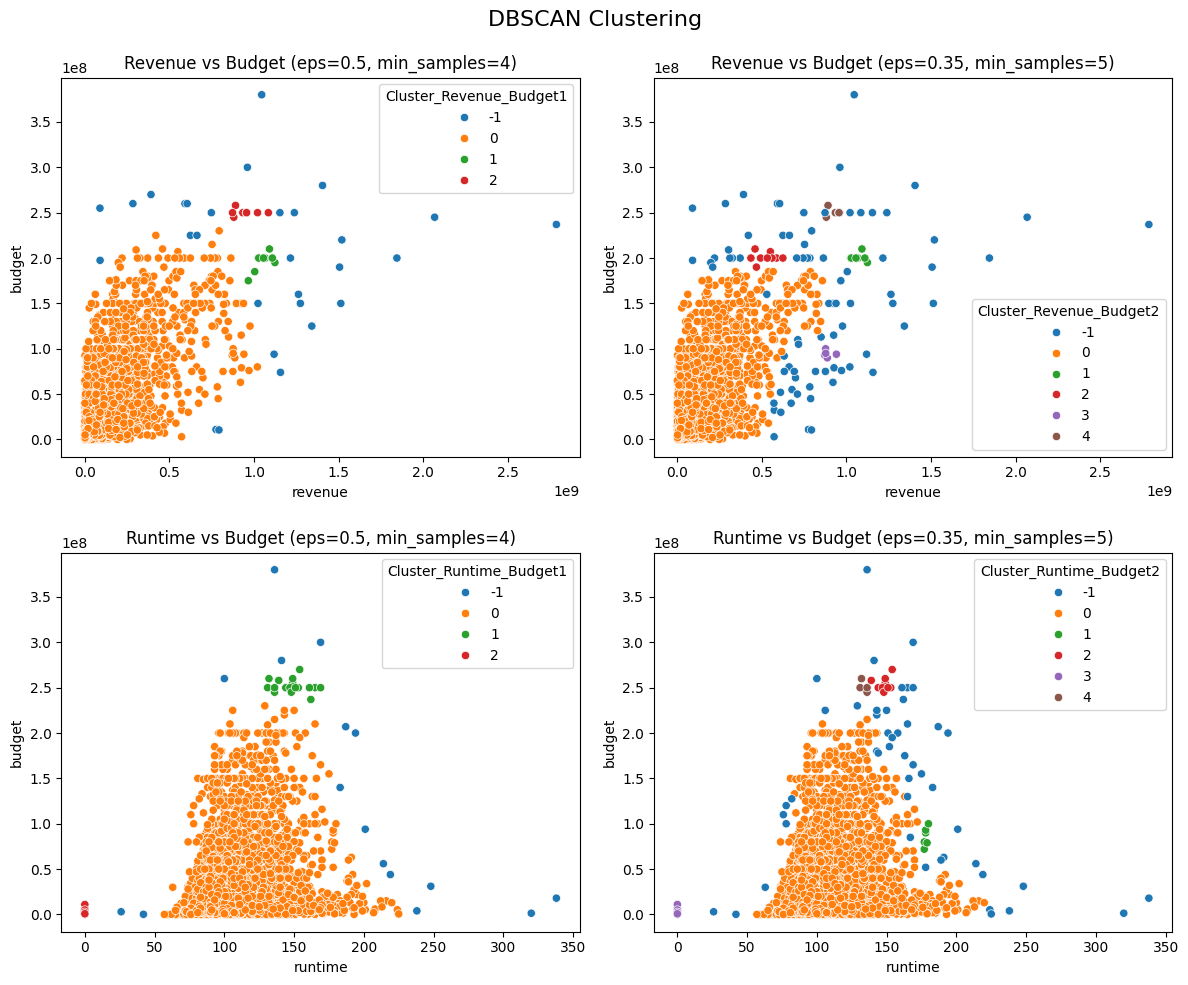

In [37]:
# --------------------------------------------------------------- DBSCAN CLUSTERING ---------------------------------------------------------------

# Set up 
fig, axes = plt.subplots(2, 2, figsize=(12, 10)) # 2 rows, 2 columns

# First combination -------------------------------------------------------------------------------------------------------------------------------
# Revenue vs Budget
dbscan1_combo1 = DBSCAN(eps=0.5, min_samples=4)
clusters1_combo1 = dbscan1_combo1.fit_predict(first_combo_scaled)
metadata_nonzero['Cluster_Revenue_Budget1'] = clusters1_combo1


dbscan2_combo1 = DBSCAN(eps=0.35, min_samples=5)
clusters2_combo1 = dbscan2_combo1.fit_predict(first_combo_scaled)
metadata_nonzero['Cluster_Revenue_Budget2'] = clusters2_combo1  

sns.scatterplot(data=metadata_nonzero, x='revenue', y='budget', hue='Cluster_Revenue_Budget1', palette='tab10', ax=axes[0, 0])
axes[0, 0].set_title('Revenue vs Budget (eps=0.5, min_samples=4)')

sns.scatterplot(data=metadata_nonzero, x='revenue', y='budget', hue='Cluster_Revenue_Budget2', palette='tab10', ax=axes[0, 1])
axes[0, 1].set_title('Revenue vs Budget (eps=0.35, min_samples=5)')


# Print number of clusters and noise point
print("First Combination")
n_clusters = len(set(clusters1_combo1)) - (1 if -1 in clusters1_combo1 else 0)
n_noise = list(clusters1_combo1).count(-1)
print("Revenue vs Budget (ep=0.5, min_samples=4)")
print(f'Number of clusters (without noise cluster): {n_clusters}')
print(f'Number of noise points: {n_noise}')

n_clusters = len(set(clusters2_combo1)) - (1 if -1 in clusters2_combo1 else 0)
n_noise = list(clusters2_combo1).count(-1)
print("Revenue vs Budget (ep=0.35, min_samples=5)")
print(f'Number of clusters (without noise cluster): {n_clusters}')
print(f'Number of noise points: {n_noise}')

# Second combination ------------------------------------------------------------------------------------------------------------------------------
# Runtime vs Budget
dbscan1_combo2 = DBSCAN(eps=0.5, min_samples=4)
clusters1_combo2 = dbscan1_combo2.fit_predict(second_combo_scaled)
metadata_nonzero['Cluster_Runtime_Budget1'] = clusters1_combo2  

dbscan2_combo2 = DBSCAN(eps=0.35, min_samples=5)
clusters2_combo2 = dbscan2_combo2.fit_predict(second_combo_scaled)
metadata_nonzero['Cluster_Runtime_Budget2'] = clusters2_combo2  

sns.scatterplot(data=metadata_nonzero, x='runtime', y='budget', hue='Cluster_Runtime_Budget1', palette='tab10', ax=axes[1, 0])
axes[1, 0].set_title('Runtime vs Budget (eps=0.5, min_samples=4)')

sns.scatterplot(data=metadata_nonzero, x='runtime', y='budget', hue='Cluster_Runtime_Budget2', palette='tab10', ax=axes[1, 1])
axes[1, 1].set_title('Runtime vs Budget (eps=0.35, min_samples=5)')

# Print number of clusters and noise points
print("\nSecond Combination")
n_clusters = len(set(clusters1_combo2)) - (1 if -1 in clusters1_combo2 else 0)
n_noise = list(clusters1_combo2).count(-1)
print("Runtime vs Budget (ep=0.5, min_samples=4)")
print(f'Number of clusters (without noise cluster): {n_clusters}')
print(f'Number of noise points: {n_noise}')

n_clusters = len(set(clusters2_combo2)) - (1 if -1 in clusters2_combo2 else 0)
n_noise = list(clusters2_combo2).count(-1)
print("Revenue vs Budget (ep=0.35, min_samples=5)")
print(f'Number of clusters (without noise cluster): {n_clusters}')
print(f'Number of noise points: {n_noise}')

# Global title
fig.suptitle('DBSCAN Clustering', fontsize=16)

# show plot
plt.tight_layout()
plt.show()


Based on the two clustering algorithms, it would seem that the DBSCAN algorithm performed better at clustering the subsets. This is because of how K-Means is highly sensitive to outliers. In our visualizations, due to these outliers, it disproportionately affected the position of the centroids. On the other hand, DBSCAN identified those outliers as noise and set those aside as a seperate cluster. This especially performed well for the first combination (Revenue vs Budget). In that subset, there were many outliers, so DBSCAN handled that better. It can also handle clusters of varying densitites; better seen in the second combination (Runtime vs Budget). Furthermore, DBSCAN was able to handle the clusters in a non-spherical way, unlike K-Means, which assumed spherical clusters.

Therefore, DBSCAN performed better than K-Means in this study as it was able to handle outliers as noise (thus filtering them out) and could find clusters of varying sizes and densities. So, it worked the best at visualizing the clusters.

## STUDY 3 - Content-Based Recommendation System

<b>Heuristic 1:</b> This heuristic is based on someone who wants to see moves that are similar in terms of viewing experience, but not necessarily related in any way. This would include movies that have the same genre (Jaccard similarity), same spoken languages (Jaccard), a similar budget (Euclidian distance), and a similar runtime (Euclidian distance).
<br>
<b>Heuristic 2:</b> This heuristic is based on movies that might be related to the one you chose. This would include movies that are part of the same collection (Jaccard similarity), have the same production company (Jaccard similarity), genre (Jaccard similarity), and a similar budget (Manhattan distance).
<br><br>
The requests will be:
- Show me movies similar to Jumanji (heuristic 1)
- Show me movies similar to Father of the Bride Part II (heuristic 2)
- Show me movies similar to Betrayal (heuristic 1)
<br><br>
<i>To find the recommendation subset, I will be creating a shortened list using the Jaccard similarities (only include scores that are higher than 0.6), then summing the distances I find and ordering based on the lowest distances. The top 10 results will show the title, genre, runtime, language, and popularity.</i>

In [39]:
def heuristic1(rowNum):
    #First we want to get the jaccard similarity for the genre
    genreTest = []
    for i in range (len(genre_names)):
        if i!=rowNum:
            jacScore = jaccard_similarity(genre_names[rowNum], genre_names[i])
            #we want at least most of the genres to be the same
            if jacScore >= 0.6:
                #return the row indices of all the movies that have the similar genres
                genreTest.append(i)

    #Now, for the remaining ones, we want to find the jaccard similarity for the same spoken languages
    languageTest = []
    for i in range (len(genreTest)):
        jacScore = jaccard_similarity(spoken_languages_names[rowNum], spoken_languages_names[genreTest[i]])
        #we want the same original language
        if jacScore >= 0.5:
            #return the row indices of all the movies that have the same genres
            languageTest.append(genreTest[i])

    #next we want to find all the sums of all the distances we want to calculate
    budgetTest = []
    totalBudgetSc = 0

    runtimeTest = []
    totalRuntimeSc = 0

    for i in range(len(languageTest)):
        budgetSc = float(euclidean_distance(metadata.iloc[rowNum]['budget'], metadata.iloc[languageTest[i]]['budget']))
        budgetTest.append((languageTest[i], budgetSc))
        totalBudgetSc+=budgetSc
            
        runtimeSc = float(euclidean_distance(metadata.iloc[rowNum]['runtime'], metadata.iloc[languageTest[i]]['runtime']))
        runtimeTest.append((languageTest[i], runtimeSc))
        totalRuntimeSc+=runtimeSc

    finalList = []
    averageBudgetSc = totalBudgetSc/len(budgetTest)
    averageRuntimeSc = totalRuntimeSc/len(runtimeTest)
    for i in range(len(runtimeTest)):
        budgetRatio = budgetTest[i][1]/averageBudgetSc
        runtimeRatio = runtimeTest[i][1]/averageRuntimeSc

        finalScore = budgetRatio + runtimeRatio
        finalList.append((runtimeTest[i][0], finalScore))
            
    #sort in ascending order
    finalList.sort(key=lambda x: x[1]) 
    return finalList[:10]

#for heuristic 2, we need to have the belongs_to_collection and production_companies value, so we need to extract the values from the json
collection_parsed = metadata['belongs_to_collection'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
collections = collection_parsed.apply(lambda x: x['name'] if isinstance(x, dict) and 'name' in x else "None")

productionComp_parsed = metadata['production_companies'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
productionComp = productionComp_parsed.apply(lambda x: ", ".join([comp['name'] for comp in x]) if isinstance(x, list) and len(x)>0 else 'None')

def heuristic2(rowNum):
    #first we want to see if it has anything in the same collection (if it even is in one)
    #if there is anything within this list, it will take priority in the end
    collectionsList = []
    if (collections[rowNum] != 'None'):
        for i in range(len(collections)):
            if i!=rowNum:
                jacScore = jaccard_similarity(collections[rowNum], collections[i])
                if jacScore >= 0.5:
                    collectionsList.append(i)
                    
    #next we check the production company
    companyList = []
    for i in range(len(productionComp)):
        if i!=rowNum:
            #we want to add things in the same collection regardless if they were made at the same company or not
            if i in collectionsList:
                companyList.append(i)
            else:
                jacScore = jaccard_similarity(productionComp[rowNum], productionComp[i])
                #they need to have at least a few production companies in common
                if jacScore >= 0.25:
                    companyList.append(i)
                    
    #next we check the genre
    genreTest = []
    for i in companyList:
        if i in collectionsList:
            genreTest.append(i)
        else:
            jacScore = jaccard_similarity(genre_names[rowNum], genre_names[i])
            #we want at least half of the genres to be the same
            if jacScore >= 0.6:
                #return the row indices of all the movies that have the similar genres
                genreTest.append(i)

    #we now want to check the scores for the budget
    budgetTest = []
    for i in range(len(genreTest)):
        budgetSc = float(manhattan_distance(metadata.iloc[rowNum]['budget'], metadata.iloc[genreTest[i]]['budget']))
        budgetTest.append((genreTest[i], budgetSc))

    #this is the list we are going to return
    finalList = []
    #start by sorting the final test list by the score
    budgetTest.sort(key=lambda x: x[1])

    dictBudTest = dict(budgetTest)
    collectionTuple = []
    for i in collectionsList:
        collectionTuple.append((i, dictBudTest.get(i)))

    collectionTuple.sort(key=lambda x: x[1])
    finalList = collectionTuple

    if (len(collectionsList)<10):
        for i in range(10-len(collectionsList)):
           if budgetTest[i] not in finalList:
               finalList.append(budgetTest[i])
    else:
        return finalList[:10]
    
    return finalList

# function to print the top 10
def printResults(top10):
    count = 1
    for index, score in top10:
        print(str(count) + ". TITLE:", metadata.iloc[index]['title'] + ", \nGENRE:", genre_names[index] + ", \nRUNTIME", metadata.iloc[index]['runtime'], "mins, \nLANGUAGES:", spoken_languages_names[index] + ",\nPOPULARITY:", metadata.iloc[index]['vote_average'])
        count+=1

# outputs
test1Row = metadata[metadata['title'] == 'GoldenEye'].index[0]
test2Row = metadata[metadata['title'] == 'Father of the Bride Part II'].index[0]
test3Row = metadata[metadata['title'] == 'Toy Story'].index[0]

print("Request 1: Show me movies similar to GoledenEye")
print("TITLE:", metadata.iloc[test1Row]['title'] + ", \nGENRE:", genre_names[test1Row] + ", \nRUNTIME", metadata.iloc[test1Row]['runtime'], "mins, \nLANGUAGES:", spoken_languages_names[test1Row] + ",\nPOPULARITY:", metadata.iloc[test1Row]['vote_average'])
print("\nHeuristic 1:")
test1 = heuristic1(test1Row)
printResults(test1)

print("\nHeuristic 2:")
test12 = heuristic2(test1Row)
printResults(test12)

print("\n\nRequest 2: Show me movies similar to Father of the Bride Part II")
print("TITLE:", metadata.iloc[test2Row]['title'] + ", \nGENRE:", genre_names[test2Row] + ", \nRUNTIME", metadata.iloc[test2Row]['runtime'], "mins, \nLANGUAGES:", spoken_languages_names[test2Row] + ",\nPOPULARITY:", metadata.iloc[test2Row]['vote_average'])
print("\nHeuristic 1:")
test2 = heuristic1(test2Row)
printResults(test2)

print("\nHeuristic 2:")
test22 = heuristic2(test2Row)
printResults(test22)

print("\n\nRequest 3: Show me movies similar to Toy Story")
print("TITLE:", metadata.iloc[test3Row]['title'] + ", \nGENRE:", genre_names[test3Row] + ", \nRUNTIME", metadata.iloc[test3Row]['runtime'], "mins, \nLANGUAGES:", spoken_languages_names[test3Row] + ",\nPOPULARITY:", metadata.iloc[test3Row]['vote_average'])
print("\nHeuristic 1:")
test3 = heuristic1(test3Row)
printResults(test3)

print("\nHeuristic 2:")
test32 = heuristic2(test3Row)
printResults(test32)


Request 1: Show me movies similar to GoledenEye
TITLE: GoldenEye, 
GENRE: Adventure, Action, Thriller, 
RUNTIME 130.0 mins, 
LANGUAGES: English, Pусский, Español,
POPULARITY: 6.6

Heuristic 1:
1. TITLE: Assassins, 
GENRE: Action, Adventure, Crime, Thriller, 
RUNTIME 132.0 mins, 
LANGUAGES: English, Español, Nederlands,
POPULARITY: 6.0
2. TITLE: The Jackal, 
GENRE: Action, Thriller, Adventure, Crime, 
RUNTIME 124.0 mins, 
LANGUAGES: English, Pусский,
POPULARITY: 6.1
3. TITLE: Ronin, 
GENRE: Action, Thriller, Crime, Adventure, 
RUNTIME 122.0 mins, 
LANGUAGES: English, Français, Pусский,
POPULARITY: 6.8
4. TITLE: The Legend of Zorro, 
GENRE: Action, Adventure, 
RUNTIME 129.0 mins, 
LANGUAGES: English, Italiano, Español,
POPULARITY: 5.9
5. TITLE: Die Hard 2, 
GENRE: Action, Thriller, 
RUNTIME 124.0 mins, 
LANGUAGES: English, Español,
POPULARITY: 6.6
6. TITLE: xXx, 
GENRE: Action, Adventure, Thriller, 
RUNTIME 124.0 mins, 
LANGUAGES: Český, English, Deutsch, Español, Pусский,
POPULARITY: 5.

My two heuristics did not exactly provide similar results because their purpose was very different. The first heuristic was made to find movies that are similar in experience (genre, length, language), while the second one is to try and find movies that can be related (like part of the same collection or made by the same company). Out of the two, I would say that the second heuristic provided better recommendations because it provides movies that we know will be related. For example, when a James Bond movie was given, the rest of the recommendations were also James Bond, meaning that it was able to find very similar movies. If it doesn't have 10 of the same movies from the collection, then heuristic 2 still gave the same value as the first heuristic, understanding when to give animated/childish shows, when to give adventurous movies, etc. So, when it comes to giving recommendations based on similarity, it seems that finding related movies will give more accurate results than just searching based on attributes (unless we used more attributes and had more movies that had the exact same answers per attribute).

## STUDY 4 - Collaborative Filtering Recommendation System

For this study, we are finding recommendations for specific users for movies they have not yet rated. Users 1, 2, and 4 were chosen, with the results displaying the movie linked by id to dataset 1 and the rating that they are predicted to have given. Next, we take out 10% of the dataset to test the accuracy of our rating system using multiple analysis methods.

In [26]:
# taken from source online
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    '''
    R: rating matrix
    P: |U| * K (User features matrix)
    Q: |D| * K (Item features matrix)
    K: latent features
    steps: iterations
    alpha: learning rate
    beta: regularization parameter'''
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if not np.isnan(R[i][j]):
                    # calculate error
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])

                    for k in range(K):
                        # calculate gradient with a and beta parameter
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])

        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if not np.isnan(R[i][j]):
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
        # 0.001: local minimum
        if e < 0.001:
            break
    return P, Q.T

#we need to create the utility matrix by doing a pivot table
ratingsMatrix = ratings.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
)

movie_ids = ratingsMatrix.columns.to_numpy()

R = ratingsMatrix.to_numpy()

#number of users
N = len(R)
#number of users
M = len(R[0])
#numbers of features
K = 5
P = np.random.rand(N,K)
Q = np.random.rand(M,K)
nP, nQ = matrix_factorization(R, P, Q, K)
#matrix with predicted ratings
nR = np.dot(nP, nQ.T)

#Find the top X recommended movies for the given user
def findRecommendedMovies(userInd, X):
    predRat = nR[userInd]

    #figure out which movies weren't rated before the prediction
    preRated = ~np.isnan(R[userInd])
    unrated = np.where(~preRated)[0]
    
    #get the previously unrated values (aka newly predicted) from the predictedRatings matrix
    unratedPred = [(i, predRat[i]) for i in unrated]
    #we want to sort from highest to lowest
    unratedPred.sort(key=lambda x:x[1], reverse=True)
    
    topX = unratedPred[:X]
    return topX

# Simulate 3 requests, and for each user, find their top X rated movies and show the results. 
#Request 1
print("Show user 1 movies they would have rated highly but haven't seen yet")
#grab the top 5 predicted ratings of the firt user (index 0)
for idx, score in findRecommendedMovies(0, 5):
    movie_id = movie_ids[idx]
    movie_title = metadata[metadata['id'] == movie_id]['title'].values[0]
    print(f"{movie_title} (Predicted Rating: {score:.2f})")

#Request 2
print("\nShow user 2 movies they would have rated highly but haven't seen yet")
#grab the top 5 predicted ratings of the second user (index 1)
for idx, score in findRecommendedMovies(1, 5):
    movie_id = movie_ids[idx]
    movie_title = metadata[metadata['id'] == movie_id]['title'].values[0]
    print(f"{movie_title} (Predicted Rating: {score:.2f})")

#Request 3
print("\nShow user 4 movies they would have rated highly but haven't seen yet")
#grab the top 5 predicted ratings of the fourth user (index 3)
for idx, score in findRecommendedMovies(3, 5):
    movie_id = movie_ids[idx]
    movie_title = metadata[metadata['id'] == movie_id]['title'].values[0]
    print(f"{movie_title} (Predicted Rating: {score:.2f})")

In [ ]:
#We now do quantitative evaluation
#split the dataset to get the "golden" 10%
ratingsFlat = ratings[['userId', 'movieId', 'rating']].dropna()
trainData, goldStandard = train_test_split(ratingsFlat, test_size = 0.1, stratify=ratingsFlat['userId'], random_state = 42)

# create a new training matrix
trainMatrix = trainData.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
)

# create the training array and get the movie ids/ user ids
RTrain = trainMatrix.to_numpy()
movie_ids_train = trainMatrix.columns.to_numpy()
user_ids_train = trainMatrix.index.to_numpy()

N = len(RTrain)
M = len(RTrain[0])
K = 5

P = np.random.rand(N, K)
Q = np.random.rand(M, K)
nP, nQ = matrix_factorization(RTrain, P, Q, K)

# MSE Evaluation
# create maps so that we can compare properly to the gold standard rows
user_index_map = {user_id: i for i, user_id in enumerate(user_ids_train)}
movie_index_map = {movie_id: i for i, movie_id in enumerate(movie_ids_train)}

trueRatings = []
predictedRatings = []

# go through the rows we set aside earlier
for index, row in goldStandard.iterrows():
    #grab the 3 values in the current row
    user_id = row['userId']
    movie_id = row['movieId']
    true_rating = row['rating']

    #if the current ids are in our predicted maps, then we grab the prediction
    if user_id in user_index_map and movie_id in movie_index_map:
        ui = user_index_map[user_id]
        mi = movie_index_map[movie_id]
        pred = nR[ui][mi]

        #we look at the original rating and compare it to the predicted rating
        true_ratings.append(true_rating)
        predicted_ratings.append(pred)

# we find the mse score between the two ratings
mse_score = mean_squared_error(true_ratings, predicted_ratings)
print(f"Evaluation 1: MSE on Gold Standard = {mse_score:.4f}")

In [ ]:
# function to check if a movie is relevant
def is_relevant(rating):
    return rating >= 4  # 4 or 5 = relevant

# calculate precision and MRR
def precision_at_k(relevant_list, k):
    return sum(relevant_list[:k]) / k

def mean_reciprocal_rank(relevant_list):
    for idx, is_rel in enumerate(relevant_list, start=1):
        if is_rel:
            return 1 / idx
    return 0

# Group gold standard by user
gs_grouped = goldStandard.groupby('userId')

# arrays
prec_at_5_list = []
prec_at_10_list = []
mrr_list = []

# loop through users and their ratings
for user_id, group in gs_grouped:
    if user_id not in user_index_map:
        continue

    # get predicted scores for the user
    user_idx = user_index_map[user_id]
    user_pred = nR[user_idx]
    
    # get only movies in the gold standard for this user that are also in the training matrix
    user_gold_movies = group['movieId'].tolist()
    user_movie_scores = []

    # filter movie by the training data
    for movie_id in user_gold_movies:
        if movie_id in movie_index_map:
            movie_idx = movie_index_map[movie_id]
            score = user_pred[movie_idx]
            user_movie_scores.append((movie_id, score))

    # sort predicted ratings (descending)
    user_movie_scores.sort(key=lambda x: x[1], reverse=True)
    top_movies = [movie_id for movie_id, _ in user_movie_scores]

    # relevance vector: 1 if relevant, 0 otherwise
    rel_vector = [int(is_relevant(group[group['movieId'] == mid]['rating'].values[0])) for mid in top_movies]

    # calculate metrics
    prec_at_5_list.append(precision_at_k(rel_vector, 5) if len(rel_vector) >= 5 else np.nan)
    prec_at_10_list.append(precision_at_k(rel_vector, 10) if len(rel_vector) >= 10 else np.nan)
    mrr_list.append(mean_reciprocal_rank(rel_vector))

# Remove NaNs before averaging
prec_at_5 = np.nanmean(prec_at_5_list)
prec_at_10 = np.nanmean(prec_at_10_list)
mean_mrr = np.mean(mrr_list)

# outputs
print(f"Evaluation 2:")
print(f"Precision@5:  {prec_at_5:.4f}")
print(f"Precision@10: {prec_at_10:.4f}")
print(f"MRR:          {mean_mrr:.4f}")

As we can see with the two evaluation results, the rating prediction system is pretty accurate. The second evaluation (which sorts with relevance) seems to get a better score (with it being closer to 1 than mse is to 0). This may be because it can tolerate more iffy values (since they are broken up into categories rather than judging the results based on just the predicted value). However, we can still see that the MSE score for the golden standard comparison is quite low, indicating a successful test in both cases.

# CONCLUSION

From this assignment, we were able to perform 5 different studies. For Study 1, we conducted similarity measures and outputted the top 10 movies based on 5 different requests. Then in Study 2, we implemented 2 clustering algorithms (K-Means and DBSCAN). We tested 2 variations for both algorithms, and then showed and analyzed all graphs to determine which clustered best. From the study, we determined DBSCAN worked best as the dataset contained outliers, which DBSCAN could handle. Study 3 had us develop 2 similarity heuristics and simulate three requests. From that, we compared these results as to which ranked better. Study 4 required us to build the R matrix. We were able to simulate 3 requests and have it return the user's top-rated movies. In this study, we performed 2 evaluations: to compare predicted scores against gold standard scores and to transform the scores so that they become binary.

In the future, we could explore how to determine the best epsilon value for DBSCAN and what algorithms exist to do that. Since the k value was found using the Elbow method, the DBSCAN could have been more accurate if we were able to also find the optimal eps value. This would have allowed for a better comparison between the two algorithms. However, since we were still able to determine which algorithm worked best, the values were used for study 2 was sufficent at this time.



# REFERENCES

- ChatGPT:
  ```python
      # how to read json values and extract just the genre part
      metadata['genres_parsed'] = metadata['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
      metadata['genre_names'] = metadata['genres_parsed'].apply(lambda x: [genre['name'] for genre in x])

      # how to prefer titles with similar lengths if the Levenshtein scores are equal
      title_scores.sort(key=lambda x: (x[1], abs(len(metadata.iloc[x[0]]['original_title']) - len(metadata.iloc[2843]['original_title']))))

      #how to see which movies weren't rated
      already_rated = ~np.isnan(R[user_index])
      unrated_indices = np.where(~already_rated)[0]
  ```
- https://ashukumar27.medium.com/similarity-functions-in-python-aa6dfe721035
- https://www.w3schools.com/python/python_ml_k-means.asp
- https://www.datacamp.com/tutorial/dbscan-clustering-algorithm
  ```python
        # Print number of clusters and noise points
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = list(clusters).count(-1)
        print(f'Number of clusters: {n_clusters}')
        print(f'Number of noise points: {n_noise}')
  ```
- https://www.youtube.com/watch?v=-EFB6icKr7E and https://github.com/Mazen-ALG/data-science/blob/master/Episode%208.6/DBSCAN.ipynb
- https://medium.com/data-science/recommendation-system-matrix-factorization-d61978660b4b